In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as pl

from cupyx import jit
from astropy.table import Table
from cupyx.profiler import benchmark

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Option 1: jit translation of a pythonic code to CUDA/С, global atomic_add()
@jit.rawkernel()
def histogram_jit(data, bins_data, n_bins, min_x, max_x, data_size):

    gid    = jit.threadIdx.x + jit.blockIdx.x * jit.blockDim.x
    stride = jit.blockDim.x * jit.gridDim.x
    
    dbin   = (max_x-min_x)/n_bins

    while gid < data_size:
        number = data[gid]
        index  = cp.int32(number / dbin)
        jit.atomic_add(bins_data, index, 1)
        gid   += stride


/opt/conda/lib/python3.10/site-packages/cupyx/jit/_interface.py:171: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
histogram_jit_cashed = cp.RawKernel(r'''
                                    extern "C" __global__ 
                                    void histogram_jit(float* data, int* bins_data, int n_bins, float min_x, float max_x, int data_size) 
                                    {
                                      float number;
                                      int index;
                                      unsigned int gid = (threadIdx.x + (blockIdx.x * blockDim.x));
                                      unsigned int stride = (blockDim.x * gridDim.x);
                                      float dbin = ((float)(max_x - min_x) / (float)(float)(n_bins));
  
                                      while ((gid < (unsigned int)(data_size))) 
                                          {
                                            number = data[gid];
                                            index = (int)(((float)number / (float)dbin));
                                            atomicAdd(&bins_data[index], 1);
                                            
                                            { unsigned int &_tmp_1 = gid; 
                                                            _tmp_1 = (_tmp_1 + stride); }
                                          }
                                    }
                                   ''', 'histogram_jit_cashed' )

In [4]:
# Option 2: Raw kernel, CUDA/C, global atomic_add
histogram_raw = cp.RawKernel(r'''
	                         extern "C" __global__
                             void histogram_raw( float* data, int* bins_data, int n_bins, float min_x, float max_x, int data_size )
                              {
                                int gid    = threadIdx.x + blockIdx.x * blockDim.x;
                                int stride = blockDim.x * gridDim.x;
                                
                                float bin_size = (max_x-min_x) / n_bins;

                                while (gid < data_size)
                                 {
                                   int index = (int)( data[gid] / bin_size );
                                  
                                   atomicAdd(&bins_data[index], 1);

                                   gid += stride;
                                 }
                              }
                             ''', 'histogram_raw')


In [5]:
# Option 3. ElementWise Kernel, CUDA/C, global memory atomic_add
histogram_elw = cp.ElementwiseKernel(
                                      'float32 data, int32 n_bins, float32 x_min, float32 x_max', # input
                                      'raw T bins_data',                                          # output

                                      '''
                                      float bin_size = (x_max - x_min) / n_bins;

                                      int index = (int)( data / bin_size);

                                      atomicAdd(&bins_data[index], 1);

                                      ''', 'histogram_elw'
                                    )


In [18]:
histogram_raw_shd = cp.RawKernel(r'''
	                         extern "C" __global__
                             void histogram_raw_shd( float* data, int* bins_data, int n_bins, float min_x, float max_x, int data_size )
                              {
                                extern __shared__ unsigned int temp[];
                                
                                if (threadIdx.x < n_bins)
                                    {
                                      temp[threadIdx.x] = 0;
                                    }
                                __syncthreads();
                                
                                int gid    = threadIdx.x + blockIdx.x * blockDim.x;
                                int stride = blockDim.x * gridDim.x;         
                                
                                float bin_size = (max_x-min_x) / n_bins;

                                while (gid < data_size)
                                 {
                                   int index = (int)( data[gid] / bin_size );
                                  
                                   atomicAdd(&temp[index], 1);

                                   gid += stride;
                                 }
                                
                                __syncthreads();
                                if (threadIdx.x < n_bins)
                                {
                                  atomicAdd( &(bins_data[threadIdx.x]), temp[threadIdx.x] );
                                }
                             
                              }''','histogram_raw_shd'
                             )

In [20]:
###### Histogram params #######
n_bins = 10
n_data = 2**20
max_x  = cp.float32(1.0)
min_x  = cp.float32(0.0)
###############################

##### DEVICE arrays #####
cp.random.seed(42)
np.random.seed(42)
d_data             = cp.random.rand(n_data).astype(cp.float32)
h_data             = np.random.rand(n_data).astype(np.float32)
d_bins_data_jit    = cp.zeros(n_bins, dtype=cp.int32)
d_bins_data_raw    = cp.zeros(n_bins, dtype=cp.int32)
d_bins_data_elw    = cp.zeros(n_bins, dtype=cp.int32)
d_bins_data_shd    = cp.zeros(n_bins, dtype=cp.int32)
#########################
#print (d_data.size )
###### GPU params #######
n_threads = 1024
smem = n_bins * cp.dtype(cp.int32).itemsize

histogram_jit((1,1,1), (n_threads,1,1), (d_data, d_bins_data_jit, n_bins, min_x, max_x, d_data.size ))
histogram_raw_shd((1,1,1),(n_threads,1,1), (d_data, d_bins_data_shd, n_bins, min_x, max_x, d_data.size), shared_mem=smem)
histogram_raw((1,1,1), (n_threads,1,1), (d_data, d_bins_data_raw, n_bins, min_x, max_x, d_data.size ))
histogram_elw( d_data, n_bins, min_x, max_x, d_bins_data_elw, block_size=n_threads )
histogram_np,_ = np.histogram(h_data, n_bins, range=(0,1))

print (d_bins_data_jit.get())
print (d_bins_data_shd.get())
print (d_bins_data_raw.get())
print (d_bins_data_elw.get())
print (histogram_np)

d_bins_data_jit    = cp.zeros(n_bins, dtype=cp.int32)
d_bins_data_raw    = cp.zeros(n_bins, dtype=cp.int32)
d_bins_data_elw    = cp.zeros(n_bins, dtype=cp.int32)
d_bins_data_shd    = cp.zeros(n_bins, dtype=cp.int32)

cp.random.seed(42)
np.random.seed(42)

[105063 105280 104997 104628 104792 104415 105203 104739 104576 104883]
[105063 105280 104997 104628 104792 104415 105203 104739 104576 104883]
[105063 105280 104997 104628 104792 104415 105203 104739 104576 104883]
[105063 105280 104997 104628 104792 104415 105203 104739 104576 104883]
[104771 104428 105053 104945 104676 104919 105088 104715 105106 104875]


In [9]:
print (histogram_jit.cached_code)


extern "C" __global__ void histogram_jit(CArray<float, 1, true, true> data, CArray<int, 1, true, true> bins_data, int n_bins, float min_x, float max_x, int data_size) {
  float number;
  int index;
  unsigned int gid = (threadIdx.x + (blockIdx.x * blockDim.x));
  unsigned int stride = (blockDim.x * gridDim.x);
  float dbin = ((float)(max_x - min_x) / (float)(float)(n_bins));
  while ((gid < (unsigned int)(data_size))) {
    number = data[gid];
    index = (int)(((float)number / (float)dbin));
    atomicAdd(&bins_data[index], 1);
    { unsigned int &_tmp_1 = gid; _tmp_1 = (_tmp_1 + stride); }
  }
}


JIT hist   counts per bin: [0 0 0 0 0 0 0 0 0 0]
RAW hist   counts per bin: [0 0 0 0 0 0 0 0 0 0]
ELW hist   counts per bin: [0 0 0 0 0 0 0 0 0 0]
NPy hist   counts per bin: [104771 104428 105053 104945 104676 104919 105088 104715 105106 104875]
EAW shared counts per bin: [0 0 0 0 0 0 0 0 0 0]
Data.size=1048576, Sum(jit)=0
Data.size=1048576, Sum(raw)=0
Data.size=1048576, Sum(elw)=0
Data.size=1048576, Sum(npy)=1048576
Data.size=1048576, Sum(shd)=0


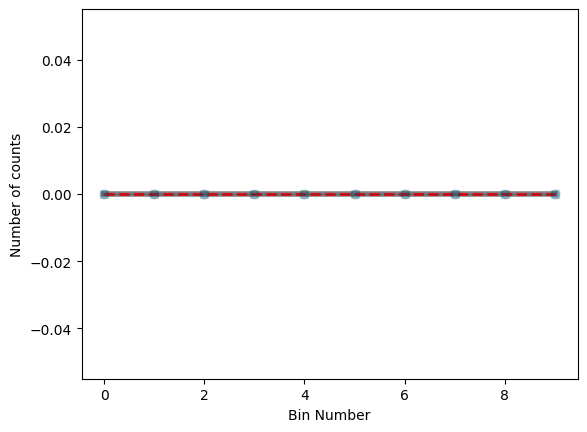

In [13]:
# Copy histogram counts from device to the host
h_bins_data_jit  = d_bins_data_jit.get()
h_bins_data_raw  = d_bins_data_raw.get()
h_bins_data_elw  = d_bins_data_elw.get()
h_bins_data_shd  = d_bins_data_shd.get()

# Print counts in each bin depending on the histogram realization
print ('JIT hist   counts per bin:', h_bins_data_jit)
print ('RAW hist   counts per bin:', h_bins_data_raw)
print ('ELW hist   counts per bin:', h_bins_data_elw)
print ('NPy hist   counts per bin:', histogram_np)
print ('EAW shared counts per bin:', h_bins_data_shd)

# Compare the number of elements in the input data array and the sum across all bins. These numbers should be identical.
print ('Data.size={:d}, Sum(jit)={:d}'.format( d_data.size, np.sum(h_bins_data_jit) ))
print ('Data.size={:d}, Sum(raw)={:d}'.format( d_data.size, np.sum(h_bins_data_raw) ))
print ('Data.size={:d}, Sum(elw)={:d}'.format( d_data.size, np.sum(h_bins_data_elw) ))
print ('Data.size={:d}, Sum(npy)={:d}'.format( d_data.size, np.sum(histogram_np) ))
print ('Data.size={:d}, Sum(shd)={:d}'.format( d_data.size, np.sum(h_bins_data_shd) ))

pl.xlabel('Bin Number')
pl.ylabel('Number of counts')
pl.plot(h_bins_data_jit, lw=4, ls='-',  c='grey',  label='jit')
pl.plot(h_bins_data_raw, lw=2, ls='--', c='red',   label='raw')
pl.plot(h_bins_data_elw, lw=1, ls='-',  c='blue',  label='elw', marker='o', alpha=0.2)
pl.plot(h_bins_data_shd, lw=1, ls='-',  c='green',  label='shd', marker='s', alpha=0.2)
#pl.plot(histogram_np,    lw=1, ls='-',  c='magenta',  label='npy', marker='t', alpha=0.2)

In [17]:
# Check the execution times as a function of number of data
to_microsec = 1000000
tab_out = Table()
fname   = 'tab_Ndata_vs_time.txt'
fmts    = {'N_data' :  '%d',
           't_jit_m':  '%.6f',
           't_jit_s':  '%.6f',
           't_raw_m':  '%.6f',
           't_raw_s':  '%.6f',
           't_shd_m':  '%.6f',
           't_shd_s':  '%.6f',
           't_elw_m':  '%.6f',
           't_elw_s':  '%.6f',
           't_npy_m':  '%.6f',
           't_npy_s':  '%.6f',
           't_cpy_m':  '%.6f',
           't_cpy_s':  '%.6f'}

n_bins = 10
#n_data = 1024#2**20
n_threads = 1024
max_x  = cp.float32(1.0)
min_x  = cp.float32(0.0)

smem  = n_bins * cp.dtype(cp.int32).itemsize

datas = [pow(10,1),pow(10,2),pow(10,3),pow(10,4),pow(10,5),pow(10,6),pow(10,7)]
t_jit_m, t_raw_m, t_elw_m, t_npy_m, t_cpy_m, t_shd_m = [],[],[],[],[],[]
t_jit_s, t_raw_s, t_elw_s, t_npy_s, t_cpy_s, t_shd_s = [],[],[],[],[],[]

for n_data in datas:
  d_bins_data_jit = cp.zeros(n_bins, dtype=cp.int32)
  d_bins_data_raw = cp.zeros(n_bins, dtype=cp.int32)
  d_bins_data_elw = cp.zeros(n_bins, dtype=cp.int32)

  cp.random.seed(42)
  d_data = cp.random.rand(n_data).astype(cp.float32)
  np.random.seed(42)
  h_data = np.random.rand(n_data).astype(np.float32)

  exe_gpu_jit = benchmark( histogram_jit, ((1,1,1), (n_threads,1,1), (d_data, d_bins_data_jit, n_bins, min_x, max_x, d_data.size )), n_repeat=5000, n_warmup=100 )
  exe_gpu_raw = benchmark( histogram_raw, ((1,1,1), (n_threads,1,1), (d_data, d_bins_data_raw, n_bins, min_x, max_x, d_data.size )), n_repeat=5000, n_warmup=100 )
  exe_gpu_shd = benchmark( histogram_raw_shd, ((1,1,1), (n_threads,1,1), (d_data, d_bins_data_raw, n_bins, min_x, max_x, d_data.size )), kwargs={'shared_mem':smem}, n_repeat=5000, n_warmup=100 )
  exe_gpu_elw = benchmark( histogram_elw, args=((d_data, n_bins, min_x, max_x, d_bins_data_elw)), kwargs={'block_size':n_threads},   n_repeat=5000, n_warmup=100 )
  exe_gpu_npy = benchmark( np.histogram,  args=((h_data, n_bins, (min_x, max_x))),   n_repeat=5000, n_warmup=100 )
  exe_gpu_cpy = benchmark( cp.histogram,  args=((d_data, n_bins, (min_x, max_x))),   n_repeat=5000, n_warmup=100 )
  
  m_jit, s_jit = np.average(exe_gpu_jit.gpu_times), np.std(exe_gpu_jit.gpu_times)
  m_raw, s_raw = np.average(exe_gpu_raw.gpu_times), np.std(exe_gpu_raw.gpu_times)
  m_shd, s_shd = np.average(exe_gpu_shd.gpu_times), np.std(exe_gpu_shd.gpu_times)
  m_elw, s_elw = np.average(exe_gpu_elw.gpu_times), np.std(exe_gpu_elw.gpu_times)
  m_npy, s_npy = np.average(exe_gpu_npy.cpu_times), np.std(exe_gpu_npy.cpu_times)
  m_cpy, s_cpy = np.average(exe_gpu_cpy.gpu_times), np.std(exe_gpu_npy.gpu_times)
    
  #print ('GPU performance:')
  print ('N_data = {:d}'.format(n_data))
  print ('Jit version:        t={:.6f}+/-{:.6f} us'.format(m_jit*to_microsec, s_jit*to_microsec))
  print ('Raw version:        t={:.6f}+/-{:.6f} us'.format(m_raw*to_microsec, s_raw*to_microsec))
  print ('ELW version:        t={:.6f}+/-{:.6f} us'.format(m_elw*to_microsec, s_elw*to_microsec))
  print ('RAW shared version: t={:.6f}+/-{:.6f} us'.format(m_shd*to_microsec, s_shd*to_microsec))
  print ('NPY version:        t={:.6f}+/-{:.6f} us'.format(m_npy*to_microsec, s_npy*to_microsec))
  print ('CPY version:        t={:.6f}+/-{:.6f} us'.format(m_cpy*to_microsec, s_cpy*to_microsec))

  d_bins_data_jit = cp.zeros(n_bins, dtype=cp.int32)
  d_bins_data_raw = cp.zeros(n_bins, dtype=cp.int32)
  d_bins_data_elw = cp.zeros(n_bins, dtype=cp.int32)
  d_bins_data_shd = cp.zeros(n_bins, dtype=cp.int32)

  t_jit_m.append(m_jit*to_microsec)
  t_jit_s.append(s_jit*to_microsec)

  t_raw_m.append(m_raw*to_microsec)
  t_raw_s.append(s_raw*to_microsec)

  t_shd_m.append(m_shd*to_microsec)
  t_shd_s.append(s_shd*to_microsec)
    
  t_elw_m.append(m_elw*to_microsec)
  t_elw_s.append(s_elw*to_microsec)
    
  t_npy_m.append(m_npy*to_microsec)
  t_npy_s.append(s_npy*to_microsec)

  t_cpy_m.append(m_cpy*to_microsec)
  t_cpy_s.append(s_cpy*to_microsec)
    
tab_out['N_data']  = datas

# JIT kernel GPU(!) mean and st.dev. times in [ms]
tab_out['t_jit_m'] = t_jit_m
tab_out['t_jit_s'] = t_jit_s
# RAW kernel GPU(!) mean and st.dev. times in [ms]
tab_out['t_raw_m'] = t_raw_m
tab_out['t_raw_s'] = t_raw_s
# RAW kernel GPU(!), shared memory, mean and st.dev times in [ms]
tab_out['t_shd_m'] = t_shd_m
tab_out['t_shd_s'] = t_shd_s
# ElementWise kernel GPU(!) mean and st.dev. times in [ms]
tab_out['t_elw_m'] = t_elw_m
tab_out['t_elw_s'] = t_elw_s
# NumPy CPU(!) mean and st.dev. times in [ms]
tab_out['t_npy_m'] = t_npy_m
tab_out['t_npy_s'] = t_npy_s
# CuPy GPU(!) mean and st.dev. times in [ms]
tab_out['t_cpy_m'] = t_cpy_m
tab_out['t_cpy_s'] = t_cpy_s

tab_out.write( fname, format='ascii.fixed_width', formats=fmts, bookend=False, delimiter=None, overwrite=True )

N_data = 10
Jit version:        t=103.373101+/-12.814315 us
Raw version:        t=22.231232+/-3.434040 us
ELW version:        t=24.308723+/-2.725736 us
RAW shared version: t=22.558509+/-2.399681 us
NPY version:        t=111.258838+/-13.016890 us
CPY version:        t=170.474822+/-13.959702 us
N_data = 100
Jit version:        t=102.913216+/-13.358790 us
Raw version:        t=22.152013+/-4.437697 us
ELW version:        t=26.709107+/-3.420912 us
RAW shared version: t=23.336442+/-3.799312 us
NPY version:        t=117.062320+/-14.295164 us
CPY version:        t=168.501126+/-15.425648 us
N_data = 1000
Jit version:        t=103.857703+/-14.212561 us
Raw version:        t=21.901133+/-2.082538 us
ELW version:        t=25.461728+/-5.091302 us
RAW shared version: t=22.155578+/-2.188055 us
NPY version:        t=153.803711+/-17.181611 us
CPY version:        t=171.160237+/-18.351993 us
N_data = 10000
Jit version:        t=112.615392+/-19.454080 us
Raw version:        t=30.751213+/-3.310325 us
ELW ve

In [22]:
# Check the execution times as a function of number of bins
to_microsec = 1000000
tab_out = Table()
fname   = 'tab_Nbins_vs_time.txt'
fmts    = {'N_bins':  '%d',
           't_jit_m':    '%.6f',
           't_jit_s':    '%.6f',
           't_raw_m':    '%.6f',
           't_raw_s':    '%.6f',
           't_shd_m':    '%.6f',
           't_shd_s':    '%.6f',
           't_elw_m':    '%.6f',
           't_elw_s':    '%.6f'}

n_data    = pow(10,5)
n_threads = 1024
max_x  = cp.float32(1.0)
min_x  = cp.float32(0.0)
cp.random.seed(42)
d_data = cp.random.rand(n_data).astype(cp.float32)

n_bins_all = [2,4,8,10,16,32,64,128,256]
t_jit_m, t_raw_m, t_elw_m, t_shd_m = [],[],[],[]
t_jit_s, t_raw_s, t_elw_s, t_shd_s = [],[],[],[]

print ('Compare execution time of CuPy kernels for different number of histogram bins')
print ('N_data = {:d}'.format(n_data))

for n_bins in n_bins_all:
  exe_gpu_jit = benchmark( histogram_jit,     ((1,1,1), (n_threads,1,1), (d_data, d_bins_data_jit, n_bins, min_x, max_x, d_data.size )),  n_repeat=5000, n_warmup=100 )
  exe_gpu_raw = benchmark( histogram_raw,     ((1,1,1), (n_threads,1,1), (d_data, d_bins_data_raw, n_bins, min_x, max_x, d_data.size )), n_repeat=5000, n_warmup=100 )
  exe_gpu_shd = benchmark( histogram_raw_shd, ((1,1,1), (n_threads,1,1), (d_data, d_bins_data_shd, n_bins, min_x, max_x, d_data.size )), kwargs={'shared_mem':n_bins * cp.dtype(cp.int32).itemsize}, n_repeat=5000, n_warmup=100 )
  exe_gpu_elw = benchmark( histogram_elw, args=((d_data, n_bins, min_x, max_x, d_bins_data_elw)), kwargs={'block_size':n_threads},    n_repeat=5000, n_warmup=100 )
  
  m_jit, s_jit = np.average(exe_gpu_jit.gpu_times), np.std(exe_gpu_jit.gpu_times)
  m_raw, s_raw = np.average(exe_gpu_raw.gpu_times), np.std(exe_gpu_raw.gpu_times)
  m_elw, s_elw = np.average(exe_gpu_elw.gpu_times), np.std(exe_gpu_elw.gpu_times)
  m_shd, s_shd = np.average(exe_gpu_shd.gpu_times), np.std(exe_gpu_shd.gpu_times)

  print ('N_bins = {:d}'.format(n_bins))
  print ('Jit version:        t={:.6f}+/-{:.6f} us'.format(m_jit*to_microsec, s_jit*to_microsec))
  print ('Raw version:        t={:.6f}+/-{:.6f} us'.format(m_raw*to_microsec, s_raw*to_microsec))
  print ('ELW version:        t={:.6f}+/-{:.6f} us'.format(m_elw*to_microsec, s_elw*to_microsec))
  print ('RAW shared version: t={:.6f}+/-{:.6f} us'.format(m_shd*to_microsec, s_shd*to_microsec))

  d_bins_data_jit = cp.zeros(n_bins, dtype=cp.int32)
  d_bins_data_raw = cp.zeros(n_bins, dtype=cp.int32)
  d_bins_data_elw = cp.zeros(n_bins, dtype=cp.int32)
  d_bins_data_shd = cp.zeros(n_bins, dtype=cp.int32)
 
  t_jit_m.append(m_jit*to_microsec)
  t_jit_s.append(s_jit*to_microsec)

  t_raw_m.append(m_raw*to_microsec)
  t_raw_s.append(s_raw*to_microsec)

  t_elw_m.append(m_elw*to_microsec)
  t_elw_s.append(s_elw*to_microsec)

  t_shd_m.append(m_shd*to_microsec)
  t_shd_s.append(s_shd*to_microsec)

tab_out['N_bins']  = n_bins_all
tab_out['t_jit_m'] = t_jit_m
tab_out['t_jit_s'] = t_jit_s

tab_out['t_raw_m'] = t_raw_m
tab_out['t_raw_s'] = t_raw_s

tab_out['t_elw_m'] = t_elw_m
tab_out['t_elw_s'] = t_elw_s

tab_out['t_shd_m'] = t_shd_m
tab_out['t_shd_s'] = t_shd_s

tab_out.write( fname, format='ascii.fixed_width', formats=fmts, bookend=False, delimiter=None, overwrite=True )

Compare execution time of CuPy kernels for different number of histogram bins
N_data = 100000
N_bins = 2
Jit version:        t=200.653338+/-42.195403 us
Raw version:        t=89.139155+/-1.676984 us
ELW version:        t=87.030976+/-2.680153 us
RAW shared version: t=57.342131+/-2.680623 us
N_bins = 4
Jit version:        t=143.061665+/-8.438739 us
Raw version:        t=62.943648+/-2.278512 us
ELW version:        t=61.465670+/-2.583132 us
RAW shared version: t=43.783776+/-3.165227 us
N_bins = 8
Jit version:        t=127.259052+/-8.544432 us
Raw version:        t=47.769453+/-1.641819 us
ELW version:        t=47.444615+/-3.448659 us
RAW shared version: t=41.612909+/-1.867882 us
N_bins = 10
Jit version:        t=132.005504+/-7.374054 us
Raw version:        t=53.094022+/-3.033228 us
ELW version:        t=51.624243+/-1.974649 us
RAW shared version: t=41.662924+/-2.134163 us
N_bins = 16
Jit version:        t=130.445267+/-11.825403 us
Raw version:        t=48.372896+/-2.223418 us
ELW version:  

In [23]:
# Check the execution times as a function of number of threads
to_microsec = 1000000
tab_out = Table()
fname   = 'tab_Nthreads_vs_time.txt'
fmts    = {'N_threads':  '%d',
           't_jit_m':    '%.6f',
           't_jit_s':    '%.6f',
           't_raw_m':    '%.6f',
           't_raw_s':    '%.6f',
           't_shd_m':    '%.6f',
           't_shd_s':    '%.6f',
           't_elw_m':    '%.6f',
           't_elw_s':    '%.6f'}


n_bins = 10
n_data = pow(10,4)
max_x  = cp.float32(1.0)
min_x  = cp.float32(0.0)
cp.random.seed(42)
d_data = cp.random.rand(n_data).astype(cp.float32)

smem = n_bins * cp.dtype(cp.int32).itemsize

n_threads_all = [16,32,64,128,256,512,1024]
t_jit_m, t_raw_m, t_elw_m, t_shd_m = [],[],[],[]
t_jit_s, t_raw_s, t_elw_s, t_shd_s = [],[],[],[]

print ('Compare execution time of CuPy kernels for different number of threads')
print ('N_data = {:d}'.format(n_data))

for n_threads in n_threads_all:
  exe_gpu_jit = benchmark( histogram_jit, ((1,1,1), (n_threads,1,1), (d_data, d_bins_data_jit, n_bins, min_x, max_x, d_data.size )),  n_repeat=5000, n_warmup=100 )
  exe_gpu_raw = benchmark( histogram_raw, ((1,1,1), (n_threads,1,1), (d_data, d_bins_data_raw, n_bins, min_x, max_x, d_data.size  )), n_repeat=5000, n_warmup=100 )
  exe_gpu_shd = benchmark( histogram_raw_shd, ((1,1,1), (n_threads,1,1), (d_data, d_bins_data_shd, n_bins, min_x, max_x, d_data.size )), kwargs={'shared_mem':smem}, n_repeat=5000, n_warmup=100 )
  exe_gpu_elw = benchmark( histogram_elw, args=((d_data, n_bins, min_x, max_x, d_bins_data_elw)), kwargs={'block_size':n_threads},    n_repeat=5000, n_warmup=100 )
  
  m_jit, s_jit = np.average(exe_gpu_jit.gpu_times), np.std(exe_gpu_jit.gpu_times)
  m_raw, s_raw = np.average(exe_gpu_raw.gpu_times), np.std(exe_gpu_raw.gpu_times)
  m_elw, s_elw = np.average(exe_gpu_elw.gpu_times), np.std(exe_gpu_elw.gpu_times)
  m_shd, s_shd = np.average(exe_gpu_shd.gpu_times), np.std(exe_gpu_shd.gpu_times)

  print ('N_threads = {:d}'.format(n_threads))
  print ('Jit version:        t={:.6f}+/-{:.6f} us'.format(m_jit*to_microsec, s_jit*to_microsec))
  print ('Raw version:        t={:.6f}+/-{:.6f} us'.format(m_raw*to_microsec, s_raw*to_microsec))
  print ('ELW version:        t={:.6f}+/-{:.6f} us'.format(m_elw*to_microsec, s_elw*to_microsec))
  print ('RAW shared version: t={:.6f}+/-{:.6f} us'.format(m_shd*to_microsec, s_shd*to_microsec))

  d_bins_data_jit = cp.zeros(n_bins, dtype=cp.int32)
  d_bins_data_raw = cp.zeros(n_bins, dtype=cp.int32)
  d_bins_data_elw = cp.zeros(n_bins, dtype=cp.int32)
  d_bins_data_shd = cp.zeros(n_bins, dtype=cp.int32)
 
  t_jit_m.append(m_jit*to_microsec)
  t_jit_s.append(s_jit*to_microsec)

  t_raw_m.append(m_raw*to_microsec)
  t_raw_s.append(s_raw*to_microsec)

  t_elw_m.append(m_elw*to_microsec)
  t_elw_s.append(s_elw*to_microsec)
    
  t_shd_m.append(m_shd*to_microsec)
  t_shd_s.append(s_shd*to_microsec)
    
tab_out['N_threads']  = n_threads_all
tab_out['t_jit_m'] = t_jit_m
tab_out['t_jit_s'] = t_jit_s

tab_out['t_raw_m'] = t_raw_m
tab_out['t_raw_s'] = t_raw_s

tab_out['t_elw_m'] = t_elw_m
tab_out['t_elw_s'] = t_elw_s

tab_out['t_shd_m'] = t_shd_m
tab_out['t_shd_s'] = t_shd_s

tab_out.write( fname, format='ascii.fixed_width', formats=fmts, bookend=False, delimiter=None, overwrite=True )

Compare execution time of CuPy kernels for different number of threads
N_data = 10000
N_threads = 16
Jit version:        t=255.264391+/-54.638437 us
Raw version:        t=148.690497+/-2.821363 us
ELW version:        t=24.653005+/-3.226569 us
RAW shared version: t=150.450753+/-6.369203 us
N_threads = 32
Jit version:        t=167.334252+/-12.009590 us
Raw version:        t=84.509324+/-2.706812 us
ELW version:        t=24.219008+/-3.076110 us
RAW shared version: t=84.363475+/-3.303482 us
N_threads = 64
Jit version:        t=135.661107+/-17.691114 us
Raw version:        t=51.760083+/-1.977374 us
ELW version:        t=24.658099+/-2.903183 us
RAW shared version: t=51.423897+/-1.710673 us
N_threads = 128
Jit version:        t=117.762176+/-9.648890 us
Raw version:        t=38.041811+/-3.272795 us
ELW version:        t=24.751584+/-2.966482 us
RAW shared version: t=36.413773+/-3.252536 us
N_threads = 256
Jit version:        t=109.057178+/-9.311523 us
Raw version:        t=29.753651+/-2.447848 us